In [1]:
import pandas as pd
import numpy as np
from glob import glob

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# set font size
font = {'size'   : 20}
mpl.rc('font', **font)

# Define input file directory

Provided you have processed the RAW files with process_inj_scan.py before!

In [4]:
base_dir = "/Users/artur/cernbox/www/HGCAL/electronics/HGCROCv2/measurements/first_tests/py_scripts/injection/"
run_dir = base_dir + "run_20190828_165320"
fnames = glob(run_dir + "/*/*.h5")
print("Found %i files" % len(fnames))

Found 1 files


In [5]:
%%time

dfs = []

for fname in sorted(fnames[:5]):
    print fname
    df = pd.read_hdf(fname, key = "data")
    dfs.append(df)

/Users/artur/cernbox/www/HGCAL/electronics/HGCROCv2/measurements/first_tests/py_scripts/injection/run_20190828_165320/chan_0/inj_scan_DAC0to4094_4081steps.h5
CPU times: user 447 ms, sys: 300 ms, total: 748 ms
Wall time: 1.44 s


# Analyze single file (one channel)

In [6]:
df_chans = dfs[0]

In [7]:
df_chans.head()

channel ch_type  adc  toa  tot  cal_dac
event                                         
1            0  normal  168  0.0  0.0        0
4           52  normal   93  0.0  0.0        0
4           53  normal   74  0.0  0.0        0
4           54  normal   49  0.0  0.0        0
4           55  normal   92  0.0  0.0        0

In [8]:
# plot all values of cal_dac
r = plt.hist(df_chans["cal_dac"], 1000)

In [9]:
# put cal_dac in 2047 range (11 bit only)
df_chans["cal_dac"] %= 2048
# sort by cal_dac value
df_chans.sort_values("cal_dac", inplace=True)

## Look for channels with high ADC value (most likely the ones with injection)

In [10]:
sel = df_chans.adc > 300

nhits = df_chans[sel].groupby("channel").size()
print nhits

channel
0    38680
dtype: int64


In [11]:
hit_chans = nhits.index.values
hit_chans

array([0])

Plot ADC vs calib DAC: all measurements (events)

Text(0,0.5,u'ADC')

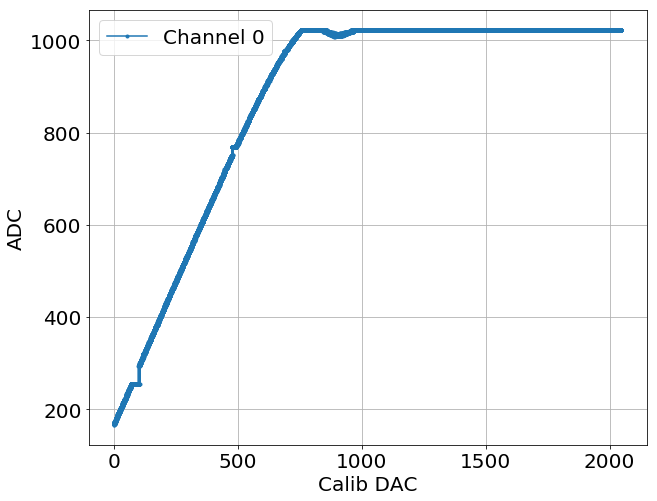

In [12]:
plt.figure(figsize = (10,8))

for chan in hit_chans:

    sel = df_chans.channel == chan
    df_sel = df_chans[sel]

    x = df_sel.cal_dac
    y = df_sel.adc
    
    plt.plot(x,y , ".-", label = "Channel %i" %chan)
    
plt.grid()
plt.legend()

plt.xlabel("Calib DAC")
plt.ylabel("ADC")

Plot ADC vs calib dac profile (mean ADC per CalDAC value)

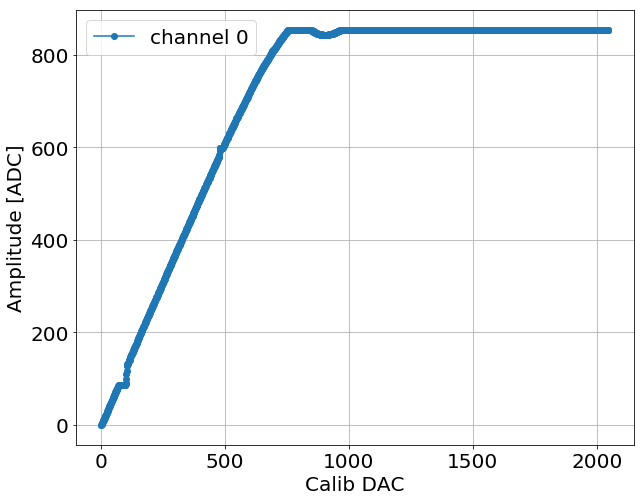

In [13]:
plt.figure(figsize = (10,8))

for chan in hit_chans:
    sel = df_chans.channel == chan

     
    # profile
    prof = df_chans[sel].groupby("cal_dac")["adc"].mean()
    x = prof.index
    y = prof.values
    
    y -= y[0]

    plt.plot(x,y , "o-", label = "channel %i" %chan)

plt.legend()
plt.xlabel("Calib DAC")
plt.ylabel("Amplitude [ADC]")

#plt.xticks(range(int(x.min()),int(x.max())))

plt.grid()

Plot TOA vs CalDAC

In [14]:
plt.figure(figsize = (10,8))

for chan in hit_chans:
    sel = df_chans.channel == chan
    #sel &= df_chans.toa > 0 # uncomment to draw TOA > 0 only
    df_sel = df_chans[sel]

    # profile
    mean_adc = df_sel.groupby("cal_dac")["toa"].median()
    x = mean_adc.index
    y = mean_adc.values

    plt.plot(x,y , "o-", label = "channel %i" %chan)

plt.legend()
plt.xlabel("Calib DAC")
plt.ylabel("Amplitude [ADC]")

#plt.xticks(range(int(x.min()),int(x.max())))

plt.grid()

Plot TOT vs CalDAC

In [15]:
plt.figure(figsize = (10,8))

for chan in hit_chans:
    sel = df_chans.channel == chan
    #sel &= df_chans.offset < 1
    df_sel = df_chans[sel]

    # profile
    mean_adc = df_sel.groupby("cal_dac")["tot"].median()
    x = mean_adc.index
    y = mean_adc.values

    plt.plot(x,y , "o-", label = "channel %i" %chan)

plt.legend()
plt.xlabel("Calib DAC")
plt.ylabel("Amplitude [ADC]")

#plt.xticks(range(int(x.min()),int(x.max())))

plt.grid()

### Plot ADC/TOT/TOA on same plot (for single channel)

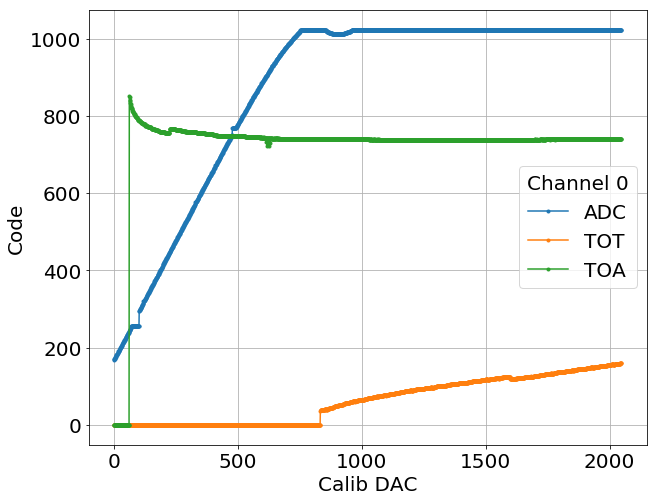

In [16]:
plt.figure(figsize = (10,8))

chan = hit_chans[0]

for yvar in ["adc","tot","toa"]:
    sel = df_chans.channel == chan
     
    # profile
    prof = df_chans[sel].groupby("cal_dac")[yvar].median()
    x = prof.index
    y = prof.values

    plt.plot(x,y , ".-", label = yvar.upper())

plt.legend(title = "Channel %i" %chan)
plt.xlabel("Calib DAC")
plt.ylabel("Code")

plt.grid()

#### Plot TOA time-walk

In [17]:
plt.figure(figsize = (10,8))

yvar = "toa"
for chan in hit_chans:
    sel = df_chans.channel == chan
    sel &= df_chans[yvar] > 0
    
    df_sel = df_chans[sel]

    # profile
    prof = df_sel.groupby("cal_dac")[yvar].mean()
    x = prof.index
    y = prof.values
    
    # normalize to last value (@ highest CalDAC)
    y -= y[-1]

    plt.plot(x,y , ".-", label = "channel %i" %chan)

plt.legend()
plt.xlabel("Calib DAC")
plt.ylabel("%s code" %yvar.upper())

#plt.xticks(range(int(x.min()),int(x.max())))

plt.grid()

Plot TOA RMS per CalDAC value

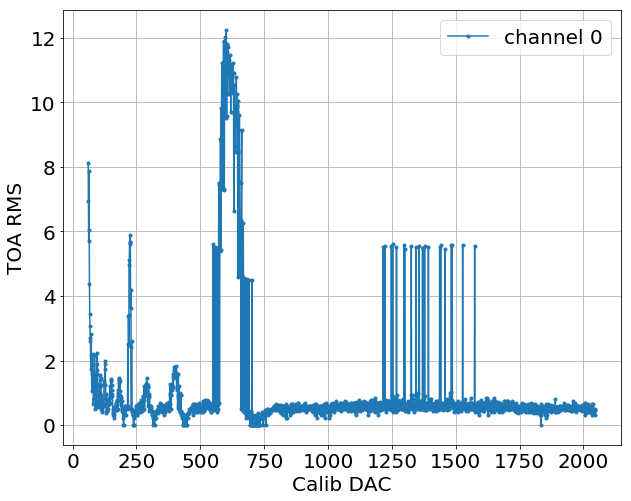

In [18]:
plt.figure(figsize = (10,8))

yvar = "toa"
for chan in hit_chans:
    sel = df_chans.channel == chan
    sel &= df_chans[yvar] > 0
    
    df_sel = df_chans[sel]

    # profile
    prof = df_sel.groupby("cal_dac")[yvar].std()
    x = prof.index
    y = prof.values
    
    plt.plot(x,y , ".-", label = "channel %i" %chan)

plt.legend()
plt.xlabel("Calib DAC")
plt.ylabel("%s RMS" %yvar.upper())

plt.grid()

### TOT

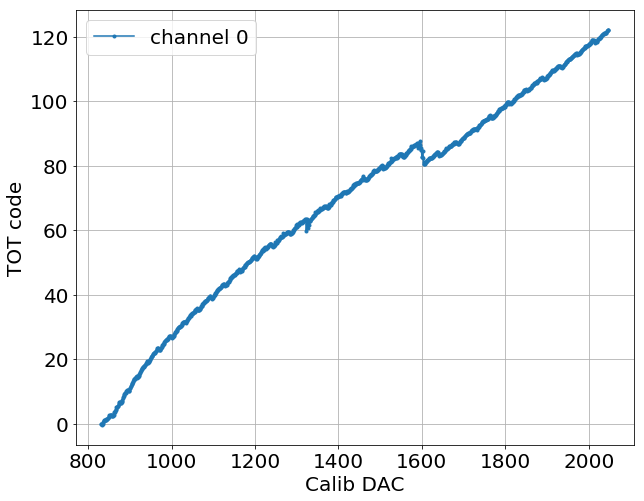

In [19]:
plt.figure(figsize = (10,8))

yvar = "tot"
for chan in hit_chans:
    sel = df_chans.channel == chan
    sel &= df_chans[yvar] > 0
    
    df_sel = df_chans[sel]

    # profile
    prof = df_sel.groupby("cal_dac")[yvar].mean()
    x = prof.index
    y = prof.values
    
    # normalize to first value (@ threshold)
    y -= y[0]

    plt.plot(x,y , ".-", label = "channel %i" %chan)

plt.legend()
plt.xlabel("Calib DAC")
plt.ylabel("%s code" %yvar.upper())


plt.grid()

Plot TOT RMS per CalDAC value

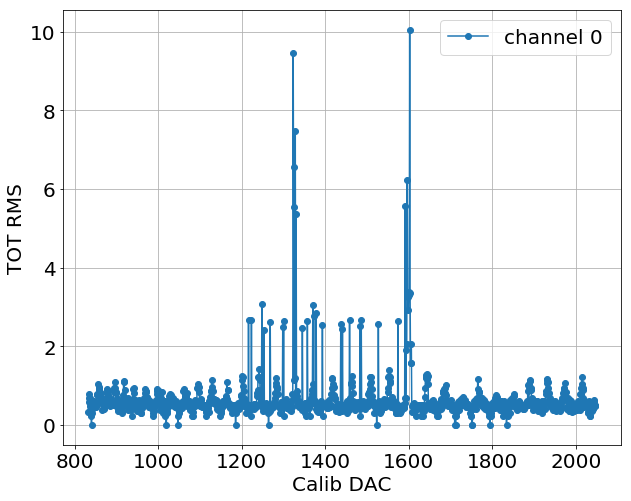

In [20]:
plt.figure(figsize = (10,8))

yvar = "tot"
for chan in hit_chans:
    sel = df_chans.channel == chan
    sel &= df_chans[yvar] > 0
    
    df_sel = df_chans[sel]

    # profile
    prof = df_sel.groupby("cal_dac")[yvar].std()
    x = prof.index
    y = prof.values
    
    plt.plot(x,y , "o-", label = "channel %i" %chan)

plt.legend()
plt.xlabel("Calib DAC")
plt.ylabel("%s RMS" %yvar.upper())

plt.grid()

# Cross-talk

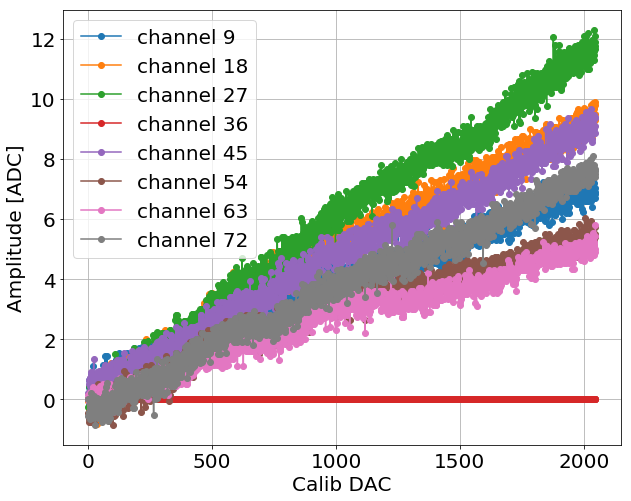

In [21]:
plt.figure(figsize = (10,8))

# reference
sel = df_chans.channel == hit_chans[0]
prof = df_chans[sel].groupby("cal_dac")["adc"].median()
x_ref = prof.index
y_ref = prof.values

y_ref -= y_ref[0]

for chan in range(0,78,9):
    
    if chan == hit_chans[0]: continue
    
    sel = df_chans.channel == chan
    #sel &= df_chans.offset < 1
    #sel &= df_chans.adc < 1023
     
    # profile
    prof = df_chans[sel].groupby("cal_dac")["adc"].mean()
    x = prof.index
    y = prof.values
    
    y -= y[0]
    
    #y/=y_ref

    plt.plot(x,y , "o-", label = "channel %i" %chan)

plt.legend()
plt.xlabel("Calib DAC")
plt.ylabel("Amplitude [ADC]")

#plt.xticks(range(int(x.min()),int(x.max())))

#plt.ylim(0,0.02)
#plt.xlim(100,2100)

plt.grid()

In [22]:
plt.figure(figsize = (10,8))

# reference
sel = df_chans.channel == hit_chans[0]
prof = df_chans[sel].groupby("cal_dac")["adc"].median()
x_ref = prof.index
y_ref = prof.values

y_ref -= y_ref[0]

#for chan in range(0,20,2):
#for chan in [0,20,35,37,38]:
for chan in range(0,20,1):
    if chan in hit_chans: continue
    
    sel = df_chans.channel == chan
    #sel &= df_chans.offset < 1
    #sel &= df_chans.adc < 1023
     
    # profile
    prof = df_chans[sel].groupby("cal_dac")["adc"].median()
    x = prof.index
    y = prof.values
    
    y -= y[0]
    
    y/=(y_ref.astype(int))

    plt.plot(x,y , "o-", label = "%i" %chan)

plt.legend(ncol = 3, fontsize = "small")
plt.xlabel("Calib DAC")
plt.ylabel("Amplitude [ADC]")

#plt.xticks(range(int(x.min()),int(x.max())))

plt.ylim(0,0.03)
#plt.xlim(100,2100)

plt.grid()

/usr/local/Cellar/ipython@5/5.7.0/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide
/usr/local/Cellar/ipython@5/5.7.0/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide


/usr/local/Cellar/ipython@5/5.7.0/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in divide
/usr/local/Cellar/ipython@5/5.7.0/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in divide


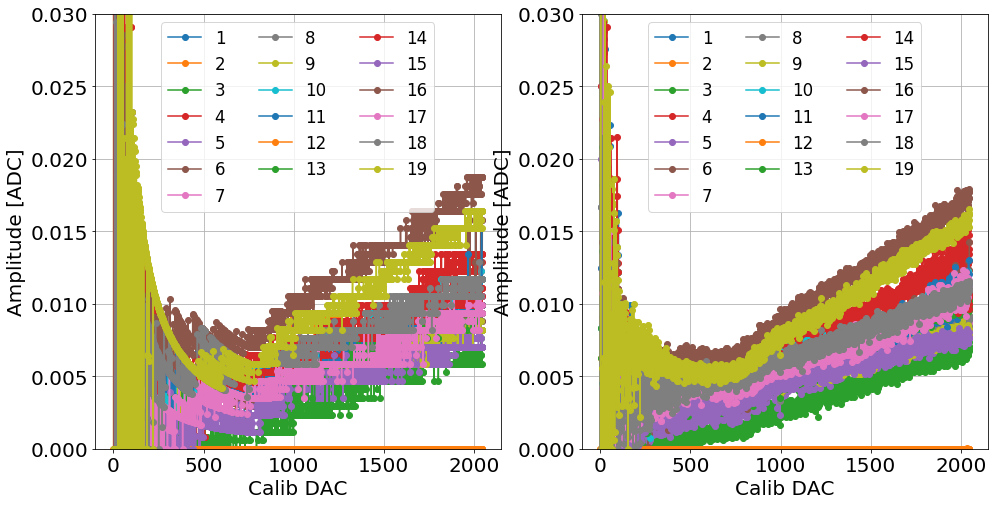

In [23]:
f, axs = plt.subplots(1,2,figsize = (16,8))


# reference
sel = df_chans.channel == hit_chans[0]
prof = df_chans[sel].groupby("cal_dac")["adc"].median()
x_ref = prof.index
y_ref = prof.values

y_ref -= y_ref[0]

#for chan in range(0,20,2):
#for chan in [0,20,35,37,38]:
for chan in range(0,20,1):
    if chan in hit_chans: continue
    
    sel = df_chans.channel == chan
    #sel &= df_chans.offset < 1
    #sel &= df_chans.adc < 1023
    
    for i in range(2):
        ax = axs[i]

        if i == 0:
            op = "median"
            prof = df_chans[sel].groupby("cal_dac")["adc"].median()
        else:
            op = "mean"
            prof = df_chans[sel].groupby("cal_dac")["adc"].mean()
        # profile
        #prof = df_chans[sel].groupby("cal_dac")["adc"].agg(op)
        x = prof.index
        y = prof.values

        y -= y[0]
        y/=(y_ref.astype(int))

        ax.plot(x,y , "o-", label = "%i" %chan)

for ax in axs:
    ax.legend(ncol = 3, fontsize = "small")
    ax.set_xlabel("Calib DAC")
    ax.set_ylabel("Amplitude [ADC]")

    #plt.xticks(range(int(x.min()),int(x.max())))

    ax.set_ylim(0,0.03)
    #plt.xlim(100,2100)

    ax.grid()

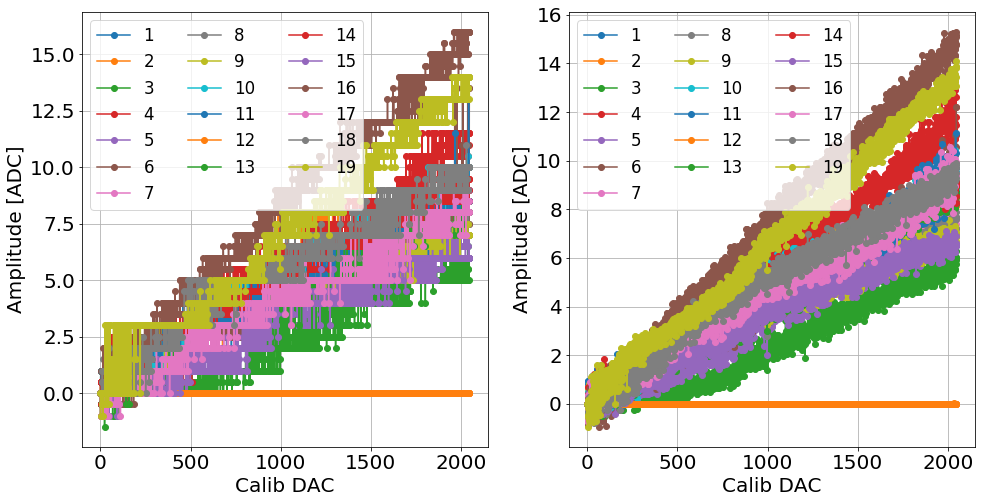

In [24]:
f, axs = plt.subplots(1,2,figsize = (16,8))


# # reference
# sel = df_chans.channel == hit_chans[0]
# prof = df_chans[sel].groupby("cal_dac")["adc"].median()
# x_ref = prof.index
# y_ref = prof.values

# y_ref -= y_ref[0]

#for chan in range(0,20,2):
#for chan in [0,20,35,37,38]:
for chan in range(0,20,1):
    if chan in hit_chans: continue
    
    sel = df_chans.channel == chan
    #sel &= df_chans.offset < 1
    #sel &= df_chans.adc < 1023
    
    for i in range(2):
        ax = axs[i]

        if i == 0: op = "median"
        else: op = "mean"
        # profile
        prof = df_chans[sel].groupby("cal_dac")["adc"].agg(op)
        x = prof.index
        y = prof.values

        y -= y[0]
        #y/=(y_ref.astype(int))

        ax.plot(x,y , "o-", label = "%i" %chan)

for ax in axs:
    ax.legend(ncol = 3, fontsize = "small")
    ax.set_xlabel("Calib DAC")
    ax.set_ylabel("Amplitude [ADC]")

    #plt.xticks(range(int(x.min()),int(x.max())))

    #ax.set_ylim(0,0.03)
    #plt.xlim(100,2100)

    ax.grid()